In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Random Forest Classifier for Variable "RACE".
- These models seek to impute the variable "RACE" in the HCUP dataset.
- As we will see, they achieve relatively high overall accuracy, but do a poor job predicting uncommon classes.
- **This demonstrates that resampling is required for this model.**

## Data Preparation and Cleaning

In [2]:
#Read in dataframe
df = pd.read_csv("data_train.csv")

In [3]:
#DATA CLEANING STEPS

#Steps to clean data by dropping columns where the number of empty rows is >= 445,000
dfComplete = df.dropna(1, thresh= 445000)
# dfComplete.shape #Results in (494932,58)

#Steps to clean data by dropping row where the number of empty columns is > 0
dfCompleteAll = dfComplete.dropna(0, how="any")
# dfCompleteAll.shape #results in a dataframe of (476155,58)

# dfCompleteAll.isnull().sum() #no more nulls in the dataset

In [4]:
#Extract Dataframe of Variables for Classification
y = dfCompleteAll[["ASOURCE", "ATYPE", "RACE", "TOTCHG", "ZIPINC_QRTL"]]
y.head()

,ASOURCE,ATYPE,RACE,TOTCHG,ZIPINC_QRTL
0,2,2,1,272123,3
1,2,2,1,209246,1
2,2,2,1,305474,1
3,2,2,1,202973,1
4,2,2,1,416072,1


In [5]:
"""The next step is to prepare variables for exploratory data analysis and feature
selection using a random forest. 

Random forest does not require standardization of continuous variables or normalization
of discrete variable. For categorical features, we will need to use pd.get_dummies or 
one hot encoding to create binary dummy variables. 
"""

#First create two dataframes of int and float values to make things easier to work with 
columnNames = dfCompleteAll.columns
dfFloat = pd.DataFrame()
dfInt = pd.DataFrame()
for name in columnNames:
    if dfCompleteAll[name].dtype == float:
        dfFloat = dfFloat.join(dfCompleteAll[name], how = "right")
    else:
        dfInt = dfInt.join(dfCompleteAll[name], how = "right")
        
#Convert all columns in DfFloat, except DISCWT, to integer values. Afterwards nominal features
#will be one-hot encoded to create dummy variables, again we will not normalize or stadardize
# numeric values. 

float_toInt = ['AGE', 'AMONTH', 'AWEEKEND', 'DIED', 'DISPUNIFORM', 'DXCCS1',
       'DXCCS2', 'FEMALE', 'LOS', 'PAY1', 'HOSP_BEDSIZE', 'HOSP_CONTROL',
       'HOSP_LOCTEACH']
for digit in float_toInt:
    dfFloat[digit] = dfFloat[digit].astype(int)

In [6]:
# In dfFloat we have the following columns and feature groupings. 
# For reference use feature_desc or call .unique() method on one of the columns

# CONTINUOUS:
dfFloatContinuous = dfFloat[["AGE", "DISCWT"]]


# NOMINAL:
dfFloatNominal = dfFloat[['AMONTH', 'DISPUNIFORM', 'DXCCS1',
       'DXCCS2', 'PAY1', 'HOSP_CONTROL','HOSP_LOCTEACH']]

# BINARY & ORDINAL
dfBinaryOrdinal = dfFloat[["DIED", "AWEEKEND", "FEMALE", "HOSP_BEDSIZE"]]

# DISCRETE
dfDiscrete = dfFloat[["LOS"]]

In [7]:
#Use pd.get_dummies to turn nominal variables into dummy variables by first setting all 
#values as string, a requirement of pd.get_dummies. 

dfFloatNominal = dfFloatNominal.loc[:].astype(str)
    
dfFloatNominal = pd.get_dummies(dfFloatNominal)
dfFloatNominal.shape 

(475155, 556)

In [8]:
#Normally here, we might turn values in dfFloatContinuous to normalized, however,
#DTs and RFs do not require this. Later if we use a different classifier, we will need
# to standardize or normalize. 

#Normalization: rescaling features to a range of [0, 1], a special case of min-max scaling.

#Standardization: Often more practical, center the feature columns at mean 0 with 
# standard deviation 1 so that the feature columns take the form of a normal distribution, 
#This make it easier to learn the weights.

In [9]:
# We can now recreate the original dfFloat dataframe as dfFloatPreprocessed which 
# will have variables ready for feature selection with RF. Next the same thing must be down
#with dfInt
list_of_dataframes = [dfFloatContinuous, dfBinaryOrdinal, dfDiscrete, dfFloatNominal]

dfFloatPreprocessed = pd.DataFrame()
for frame in list_of_dataframes:
    dfFloatPreprocessed = dfFloatPreprocessed.join(frame, how = "right")
dfFloatPreprocessed.shape

(475155, 563)

In [10]:
#Prepare dfInt for preprocessing, starting with dropping respone variables
dfInt = dfInt.drop(["ASOURCE", "ATYPE", "RACE", "TOTCHG", "ZIPINC_QRTL"], axis= 1)
'''
Uncomment the code below to look at values in each column to see what needs to be dropped 
'''

# columnNamesInt = dfInt.columns

# for name in columnNamesInt:
#     print(name, dfInt[name].unique()) #Any values where 0,1 or ordinal e.g., DQTR we are good

'\nUncomment the code below to look at values in each column to see what needs to be dropped \n'

In [11]:
#CMs are all binary, therefore, create a separate dataframe for these columns: 
dfCm = dfInt[['CM_AIDS', 'CM_ALCOHOL', 'CM_ANEMDEF',
       'CM_ARTH', 'CM_BLDLOSS', 'CM_CHF', 'CM_CHRNLUNG', 'CM_COAG',
       'CM_DEPRESS', 'CM_DM', 'CM_DMCX', 'CM_DRUG', 'CM_HTN_C', 'CM_HYPOTHY',
       'CM_LIVER', 'CM_LYMPH', 'CM_LYTES', 'CM_METS', 'CM_NEURO', 'CM_OBESE',
       'CM_PARA', 'CM_PERIVASC', 'CM_PSYCH', 'CM_PULMCIRC', 'CM_RENLFAIL',
       'CM_TUMOR', 'CM_ULCER', 'CM_VALVE', 'CM_WGHTLOSS']]

#Update the dfInt dataframe to a new dataframe:
dfIntShort = dfInt.drop(['CM_AIDS', 'CM_ALCOHOL', 'CM_ANEMDEF',
       'CM_ARTH', 'CM_BLDLOSS', 'CM_CHF', 'CM_CHRNLUNG', 'CM_COAG',
       'CM_DEPRESS', 'CM_DM', 'CM_DMCX', 'CM_DRUG', 'CM_HTN_C', 'CM_HYPOTHY',
       'CM_LIVER', 'CM_LYMPH', 'CM_LYTES', 'CM_METS', 'CM_NEURO', 'CM_OBESE',
       'CM_PARA', 'CM_PERIVASC', 'CM_PSYCH', 'CM_PULMCIRC', 'CM_RENLFAIL',
       'CM_TUMOR', 'CM_ULCER', 'CM_VALVE', 'CM_WGHTLOSS'],axis = 1)

# columnNamesInt = dfIntShort.columns
# for name in columnNamesInt:
#     print(name, dfIntShort[name].unique()) #Any values where 0,1 or ordinal e.g., DQTR we are good

In [12]:
#Continue evaluating values in each column

#Since NDX, NPR, ORPROC, TOTAL_DISC are all either Binary or Discerete variables, create a separate dataframe
dfIntBinaryDiscrete = dfIntShort[["NDX", "NPR", "ORPROC", "TOTAL_DISC"]]

# Since DQTR, HOSPID, MDC, NIS_STRATUM, HOSP_REGION are all nominal variables, create a separate dataframe to 
#turn these into dummy variables. ALSO Drop "KEY" as this is the record id field: 
dfIntToDummies = dfIntShort.drop(["KEY", "NDX", "NPR", "ORPROC", "TOTAL_DISC"], axis= 1)


In [13]:
#Turn values in DQTR, HOSPID, MDC, NIS_STRATUM, HOSP_REGION to string
dfIntToDummies = dfIntToDummies.loc[:].astype(str)

#Use pd.get_dummies to turn nominal string values to binary dummy variables
dfIntToDummies = pd.get_dummies(dfIntToDummies)
# dfIntToDummies.head()

In [14]:
#Recombinet the three dataframes into a new preprocessed dataframe called dfIntPreprocessed
intRecombine = [dfIntToDummies, dfCm, dfIntBinaryDiscrete]

dfIntPreprocessed = pd.DataFrame()
for df in intRecombine:
    dfIntPreprocessed = dfIntPreprocessed.join(df, how = "right")
    
# dfIntPreprocessed.shape

In [15]:
#Combine the now preprocessed dfInt and dfFloat dataframes back in a single dataframe of either discrete, continuous,
#or binary variables. 
dfPreprocessed = dfFloatPreprocessed.join(dfIntPreprocessed, how = "right")
arrayPreprocessed = np.array(dfPreprocessed)
dfPreprocessed.head() #these are our predictors

,AGE,DISCWT,DIED,AWEEKEND,FEMALE,HOSP_BEDSIZE,LOS,AMONTH_1,AMONTH_10,AMONTH_11,...,CM_PULMCIRC,CM_RENLFAIL,CM_TUMOR,CM_ULCER,CM_VALVE,CM_WGHTLOSS,NDX,NPR,ORPROC,TOTAL_DISC
0,48,4.671227,0,0,0,1,83,0,0,1,...,0,0,0,0,0,1,18,7,1,409
1,66,4.671227,0,0,0,1,50,0,0,1,...,0,0,0,0,0,1,18,8,0,409
2,53,4.671227,0,0,0,1,65,0,0,1,...,0,0,0,0,0,1,18,6,0,409
3,27,4.671227,0,0,1,1,59,0,0,1,...,0,0,0,0,0,1,18,4,0,409
4,48,4.671227,1,0,0,1,77,0,0,1,...,1,1,0,0,0,1,18,8,0,409


## RACE Variable Distribution

1    326960
2     83746
3     38750
6     18408
4      6561
5       730
Name: RACE, dtype: int64

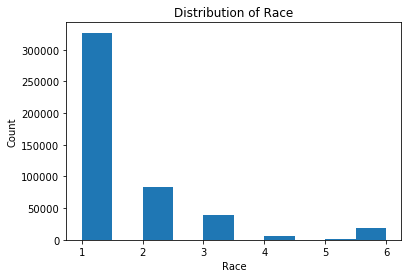

In [16]:
#Look at distribution of Race
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(y["RACE"], histtype="bar")
plt.title("Distribution of Race")
plt.ylabel("Count")
plt.xlabel("Race")

y.RACE.value_counts()

### Fit and Tune a Random Forest
- dfPreprocessed contains all our predictor variables, transformed when necessary.
- "y" contains our five outcome variables: RACE, ZIPINC, ASOURCE, ATYPE, and TOTCH; all except TOTCH are categorical.

In [17]:
#we will start with a train/test split. Some argue that since a random forest has out-of-bag (OOB) scores to
#provide an unbiased estimation of test error that you don't need this
#however, for our purposes, we will be predicting classes on real life data and want to see how we might do
X_train, X_test, y_train, y_test = train_test_split(dfPreprocessed, y, test_size=0.33, random_state=12)

In [19]:
y_train.RACE.value_counts()

1    218876
2     56256
3     25949
6     12383
4      4398
5       491
Name: RACE, dtype: int64

In [20]:
y_train.RACE.value_counts(normalize=True)

1    0.687526
2    0.176710
3    0.081510
6    0.038897
4    0.013815
5    0.001542
Name: RACE, dtype: float64

In [30]:
#now to instantiate our classifier object; these parameters are obviously important

#we use an "eyeball" test to set these initial parameters
rfc = RandomForestClassifier(n_jobs=-1,max_features='auto',n_estimators=200,max_depth=50,min_samples_split=100,
                             min_samples_leaf=50,oob_score = True, random_state=12)

#'auto' = sqrt

#begin by fitting for one outcome variable; doing all 5 would take more time
rfc.fit(X_train, y_train.RACE)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=50,
            min_samples_split=100, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=True, random_state=12,
            verbose=0, warm_start=False)

In [31]:
#look at estimated test error via oob_score_ attribute
rfc.oob_score_ #this is a good sign!

0.74714860547882378

In [35]:
#"true" test accuracy on data the model hasn't seen
predicted_classes = rfc.predict(X_test)
accuracy = accuracy_score(y_test.RACE, predicted_classes)
print('Test Set Accuracy Score: {}'.format(accuracy))

Test Set Accuracy Score: 0.7495503883879032


In [40]:
#see where the errors are
pd.crosstab(y_test.RACE, predicted_classes, rownames=['Actual Race'], colnames=['Predicted Race'])

Predicted Race,1,2,3,6
Actual Race,,,,
1,104875,3004,202,3
2,17004,8172,2314,0
3,7087,2183,3530,1
4,1630,496,37,0
5,219,10,10,0
6,3125,1547,399,954


### Yikes. This model never predicts classes 4 or 5. As we can see, there is a big potential practical implication of never predicting two races.

Let's try increasing tree depth and min_samples_leaf to *restore* some variance and let our model predict less common races.

In [41]:
rfc_1 = RandomForestClassifier(n_jobs=-1,max_features='auto',n_estimators=200,max_depth=100,min_samples_split=100,
                             min_samples_leaf=1,oob_score = True, random_state=12)

rfc_1.fit(X_train, y_train.RACE)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=100, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=True, random_state=12,
            verbose=0, warm_start=False)

In [42]:
rfc_1.oob_score_

0.76370255659597996

In [43]:
predicted_1 = rfc_1.predict(X_test)
accuracy_1 = accuracy_score(y_test.RACE, predicted_1)
print('Test Set Accuracy Score: {}'.format(accuracy_1))

Test Set Accuracy Score: 0.766342266042525


In [44]:
rfc_1_ct = pd.crosstab(y_test.RACE, predicted_1, rownames=['Actual Race'], colnames=['Predicted Race'])
rfc_1_ct

Predicted Race,1,2,3,4,5,6
Actual Race,,,,,,
1,104221,3381,412,2,0,68
2,14850,10211,2321,0,0,108
3,6319,1982,4403,0,0,97
4,1645,417,82,0,0,19
5,204,13,21,0,1,0
6,2857,1310,530,0,0,1328


Better...but still pretty bad.

### Crank down samples needed to make a split. This should make it easier to find small leaves with uncommon race classes.

In [45]:
rfc_2 = RandomForestClassifier(n_jobs=-1,max_features='auto',n_estimators=200,max_depth=100,min_samples_split=10,
                             min_samples_leaf=1,oob_score = True, random_state=12)

rfc_2.fit(X_train, y_train.RACE)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=True, random_state=12,
            verbose=0, warm_start=False)

In [46]:
rfc_2.oob_score_

0.76829180186773804

In [47]:
predicted_2 = rfc_2.predict(X_test)
accuracy_2 = accuracy_score(y_test.RACE, predicted_2)
print('Test Set Accuracy Score: {}'.format(accuracy_2))

Test Set Accuracy Score: 0.7702516549533807


In [48]:
rfc_2_ct = pd.crosstab(y_test.RACE, predicted_2, rownames=['Actual Race'], colnames=['Predicted Race'])
rfc_2_ct

Predicted Race,1,2,3,4,5,6
Actual Race,,,,,,
1,103673,3655,606,9,0,141
2,13956,11071,2277,5,0,181
3,5942,2170,4579,2,0,108
4,1617,407,107,1,0,31
5,198,15,24,0,2,0
6,2766,1249,555,4,0,1451


Still getting better, but still not making a whole lot of predictions for race classes 4 and 5.

In [19]:
rfc_3 = RandomForestClassifier(n_jobs=-1,max_features='auto',n_estimators=200,max_depth=150,min_samples_split=2,
                             min_samples_leaf=1,oob_score = True, random_state=12)

#this is what I call the "high variance" model -- max depth 150; only 1 sample needed to split
rfc_3.fit(X_train, y_train.RACE)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=150, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=True, random_state=12, verbose=0, warm_start=False)

In [20]:
rfc_3.oob_score_

0.7651380700040521

In [21]:
predicted_3 = rfc_3.predict(X_test)
accuracy_3 = accuracy_score(y_test.RACE, predicted_3)
print('Test Set Accuracy Score: {}'.format(accuracy_3))

Test Set Accuracy Score: 0.767987653218709


In [22]:
rfc_3_ct = pd.crosstab(y_test.RACE, predicted_3, rownames=['Actual Race'], colnames=['Predicted Race'])
rfc_3_ct

Predicted Race,1,2,3,4,5,6
Actual Race,,,,,,
1,103091,3861,789,81,1,261
2,13608,11309,2236,30,1,306
3,5800,2318,4503,27,1,152
4,1576,396,124,21,0,46
5,195,14,25,1,3,1
6,2729,1211,560,29,1,1495


In [24]:
rfc_3_report = classification_report(y_test.RACE, predicted_3)
print(rfc_3_report)

             precision    recall  f1-score   support

          1       0.81      0.95      0.88    108084
          2       0.59      0.41      0.49     27490
          3       0.55      0.35      0.43     12801
          4       0.11      0.01      0.02      2163
          5       0.43      0.01      0.02       239
          6       0.66      0.25      0.36      6025

avg / total       0.74      0.77      0.74    156802



### It appears we have found our trade-off point between overall accuracy and more class 4/5 predictions; Disappointingly, we aren't getting 4/5 predictions right -- we're just making more of them.

In [57]:
len(y_test)

156802

In [54]:
rfc_3_ct.sum(axis=1)

Actual Race
1    108084
2     27490
3     12801
4      2163
5       239
6      6025
dtype: int64

In [55]:
rfc_3_ct.sum()

Predicted Race
1    126999
2     19109
3      8237
4       189
5         7
6      2261
dtype: int64

Our model isn't actually that good. It just guesses class 1 alot, and is right alot because class 1 is often right.
**If you just guessed Race Class = 1 every single time, you'd have an accuracy rate of 68.9%**. 

### We will need to pursue data resampling to improve our model.